In [1]:
# define a pytensor Op for our likelihood function
from pl_temp_fit import fit_experimental_PLT
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

Running on PyMC v5.10.3
Running on PyMC v5.10.3


Running on PyMC v5.10.3
experiemental_data/Y6_SWrecipe.csv


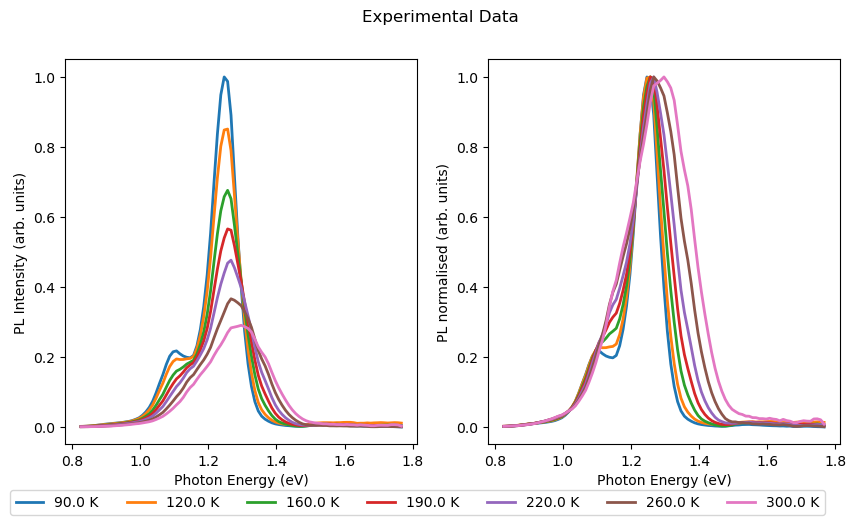

In [2]:
import importlib
importlib.reload(fit_experimental_PLT)
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[3]#3 for y6, 18 for ITIC,12 for L8BO
print(csv_name)
Exp_data, temperature_list, hws = fit_experimental_PLT.read_data(csv_name)
fig,ax = fit_experimental_PLT.plot_data(Exp_data, temperature_list, hws,title="Experimental Data")
#fig.tight_layout()


In [3]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.005, 10, 0.005, 0.05
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
date=datetime.datetime.now().strftime("%Y_%m_%d")
# generate the data
save_folder = (
    f"fit_experimental/{date}/{csv_name.split('/')[-1]}/num_samples="
    + str(num_samples)
    + " num_tune=" + str(num_tune)
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

In [4]:
hws

array([0.82666667, 0.83666667, 0.84666667, 0.85666667, 0.86666667,
       0.87666667, 0.88666667, 0.89666667, 0.90666667, 0.91666667,
       0.92666667, 0.93666667, 0.94666667, 0.95666667, 0.96666667,
       0.97666667, 0.98666667, 0.99666667, 1.00666667, 1.01666667,
       1.02666667, 1.03666667, 1.04666667, 1.05666667, 1.06666667,
       1.07666667, 1.08666667, 1.09666667, 1.10666667, 1.11666667,
       1.12666667, 1.13666667, 1.14666667, 1.15666667, 1.16666667,
       1.17666667, 1.18666667, 1.19666667, 1.20666667, 1.21666667,
       1.22666667, 1.23666667, 1.24666667, 1.25666667, 1.26666667,
       1.27666667, 1.28666667, 1.29666667, 1.30666667, 1.31666667,
       1.32666667, 1.33666667, 1.34666667, 1.35666667, 1.36666667,
       1.37666667, 1.38666667, 1.39666667, 1.40666667, 1.41666667,
       1.42666667, 1.43666667, 1.44666667, 1.45666667, 1.46666667,
       1.47666667, 1.48666667, 1.49666667, 1.50666667, 1.51666667,
       1.52666667, 1.53666667, 1.54666667, 1.55666667, 1.56666

Running on PyMC v5.10.3
Running on PyMC v5.10.3


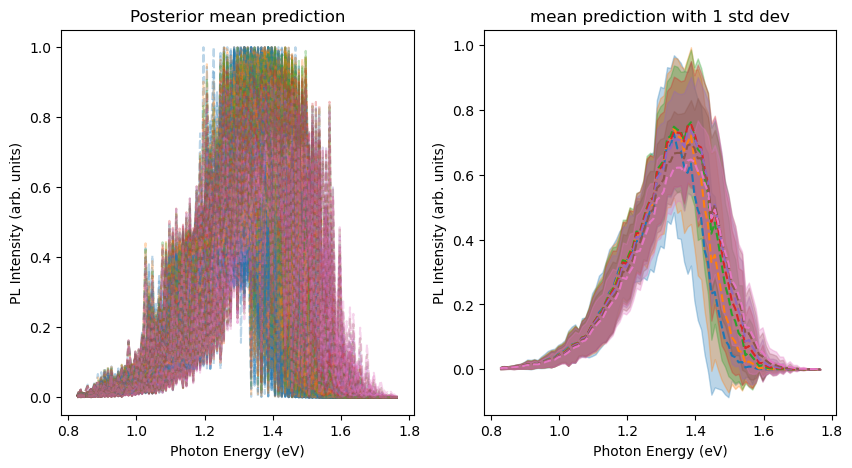

In [5]:
from pl_temp_fit import test_FIT_NEW
import importlib
importlib.reload(fit_experimental_PLT)
importlib.reload(PLPYMCModel)
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.001, 0.1, 0.05, 0.00
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
truemodel_pl, true_parameters = fit_experimental_PLT.generate_data(temperature_list, hws, **model_config)
true_model_pl_list,variance,arg_max_variance,co_var_mat = fit_experimental_PLT.plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True)

In [1]:
# add noise to the data

variance_data = co_var_mat.diagonal().reshape(hws.shape[0],-1).copy()#variance.copy()
argmax_data = np.argmax(Exp_data, axis=0)
for i in range(len(temperature_list)):
    variance_data[:, i] = np.roll(variance_data[:, i], argmax_data[i]-arg_max_variance[i])
variance_data = variance_data+0.005
np.fill_diagonal(co_var_mat, variance_data.reshape(-1,1))
fit_experimental_PLT.plot_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)



KeyboardInterrupt



In [2]:
## initialise the model and run the fit
importlib.reload(PLPYMCModel)
model = PLPYMCModel.PLPYMCModel()
for key, value in model_config.items():
    model.model_config[key] = value
print(model.model_config)      
model.sampler_config['step'] = "Metropolis(tune_interval =50)"#"[pm.DEMetropolis([self.E,self.LI,self.sigma_E]),pm.DEMetropolis([self.L0,self.H0])]"  
print(model.sampler_config)
model.fit(X, Exp_data,co_var_mat = co_var_mat, draws=num_samples, tune=num_tune, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)
print(az.summary(model.idata))
model.plot_trace(true_parameters=None, save_folder=save_folder, savefig=True)
# save the data
model.idata.to_netcdf(save_folder + "/idata.nc")
model.plot_posterior_prediction(Exp_data,  temperature_list, hws, save_folder=save_folder, savefig=True)
fname = "/model.nc"
model.save(save_folder+fname)

NameError: name 'importlib' is not defined

Running on PyMC v5.10.3
Running test number 0
{'num_samples': 1000, 'num_tune': 1000, 'sigma': 0.001, 'Temp_std_err': 5, 'hws_std_err': 0.001, 'relative_intensity_std_error': 0.01}
17
size of hw is (95,)
size of temperature_list is (7,)


{'number_free_parameters': 5, 'E': {'min': 1.0, 'max': 2.0}, 'sigma_E': {'min': 0.001, 'max': 0.03}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.15, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 5, 'hws_std_err': 0.001, 'relative_intensity_std_error': 0.01, 'sigma': 0.001}
{'draws': 10, 'tune': 5, 'chains': 3, 'step': 'Metropolis(tune_interval =200)', 'return_inferencedata': True}
{'draws': 1000, 'tune': 1000, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [sigma_E]
>Metropolis: [LI]
>Metropolis: [L0]
>Metropolis: [H0]


/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


ValueError: Not enough samples to build a trace.

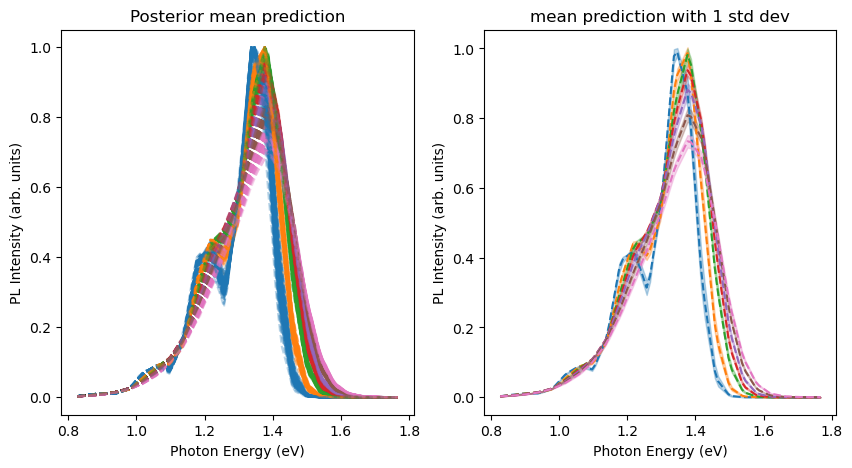

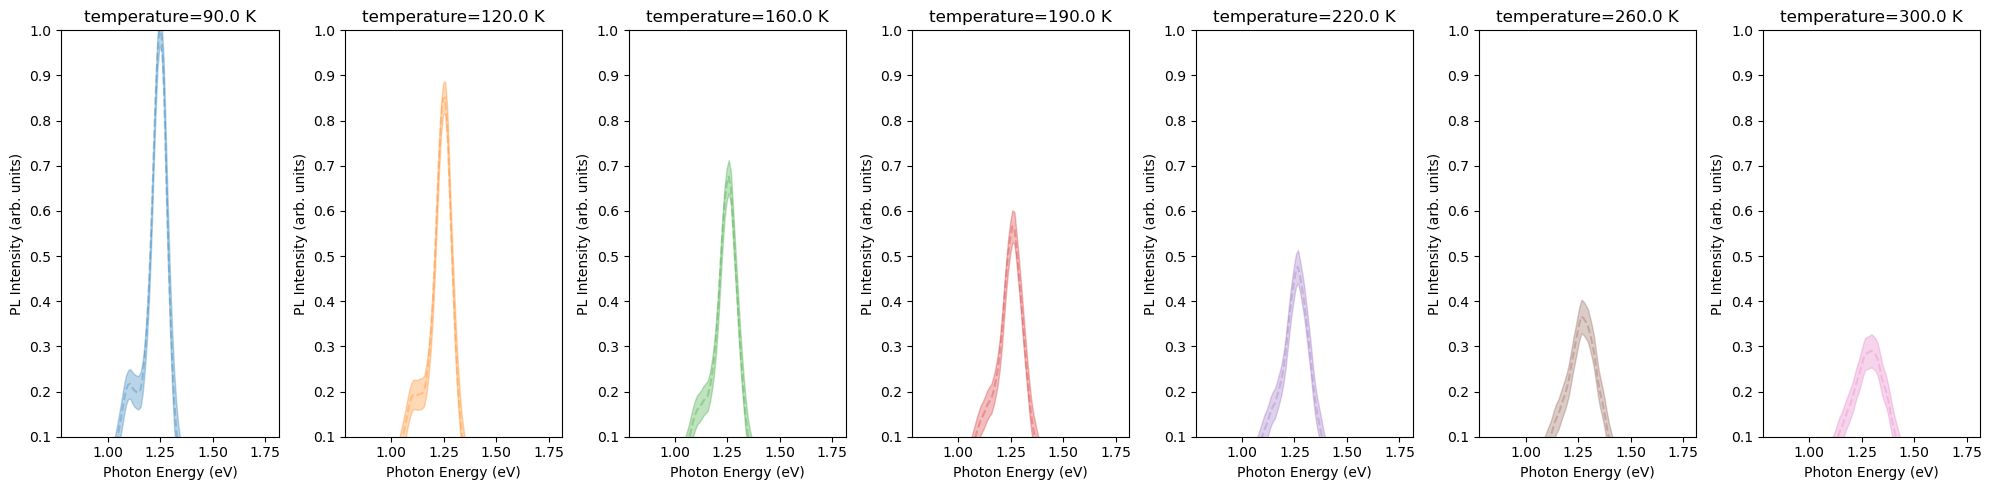

In [8]:
importlib.reload(PLPYMCModel)

%run src/pl_temp_fit/fit_experimental_PLT.py --data_file {csv_name} --test_number 0

In [10]:
# submit to HPC
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=16:mem=16gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/fit_experimental_PLT.py --test_number 12 --data_file {csv_name} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/Runtest_Experiment_Y6_12.sh', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  

!qsub  -e ./cache -o ./cache HPC_bash_script/Runtest_Experiment_Y6_12.sh

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


# Analyse fit results


Running on PyMC v5.10.3
experiemental_data/Y6_SWrecipe.csv


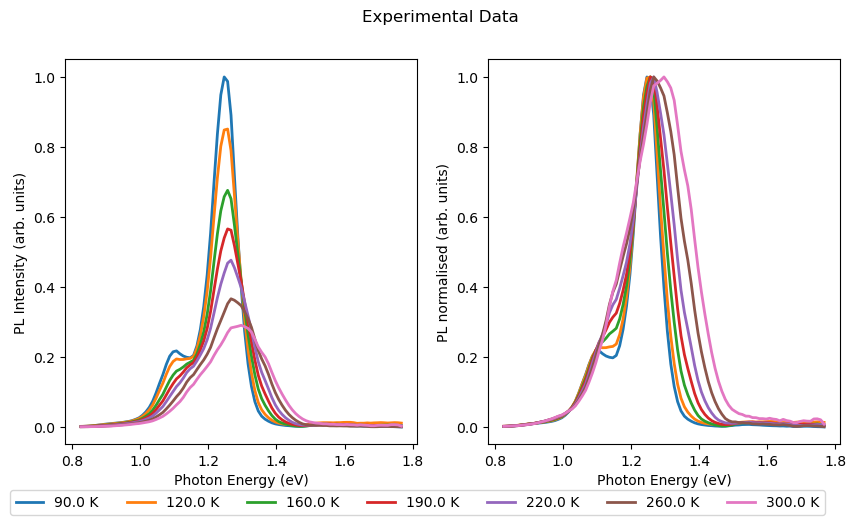

In [7]:
# analyse results
import importlib
importlib.reload(fit_experimental_PLT)
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[3]#3 for y6, 18 for ITIC,12 for L8BO
print(csv_name)
Exp_data, temperature_list, hws = fit_experimental_PLT.read_data(csv_name)
fit_experimental_PLT.plot_data(Exp_data, temperature_list, hws,title="Experimental Data")

import arviz
model = PLPYMCModel.PLPYMCModel()
folder = glob.glob(f"fit_experimental/2024_01_23/{csv_name.split('/')[-1]}/*")
exp_data_dict_exp = {}
model_dict_exp = {}
for f in folder:
    
    name = f.split('/')[-1]
    if 'idata.nc' in os.listdir(f):
        exp_results = arviz.from_netcdf(f'{f}/idata.nc')
        exp_data_dict_exp[name] = exp_results
    if 'model.nc' in os.listdir(f):
        model_2 = model.load(f'{f}/model.nc')
        model_dict_exp[name] = model_2

In [8]:
# put results into a dataframe
list_params = []

for key,model in model_dict_exp.items():
    params_dict = {}
    for x in key.split(' '):
        params_dict[x.split('=')[0]]=float(x.split('=')[1])
    df_summary = arviz.summary(model.idata)
    print(name, df_summary['r_hat'].values.max())
    params_dict['r_hat'] = df_summary['r_hat'].values.max()
    params_dict['mean'] = df_summary['mean'].values
    params_dict['key'] = key
    list_params.append(params_dict)

import pandas as pd
df = pd.DataFrame.from_records(list_params)
df

num_samples=4000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.1 3.9
num_samples=4000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.1 3.89
num_samples=4000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.05 relative_intensity_std_error=0.1 3.98


,num_samples,num_tune,sigma,temperature_list,number_free_parameters,Temp_std_err,hws_std_err,relative_intensity_std_error,r_hat,mean,key
0,100.0,20.0,0.010,7.0,5.0,5.0,0.001,0.01,3.90,"[1.394, 0.014, 0.061, 0.11, 0.16]",num_samples=100 num_tune=20 sigma=0.01 tempera...
1,1000.0,1000.0,0.001,7.0,5.0,5.0,0.001,0.01,3.89,"[1.361, 0.011, 0.058, 0.099, 0.161]",num_samples=1000 num_tune=1000 sigma=0.001 tem...
2,2000.0,2000.0,0.002,7.0,5.0,2.0,0.005,0.01,3.98,"[1.529, 0.001, 0.114, 0.096, 0.163]",num_samples=2000 num_tune=2000 sigma=0.002 tem...


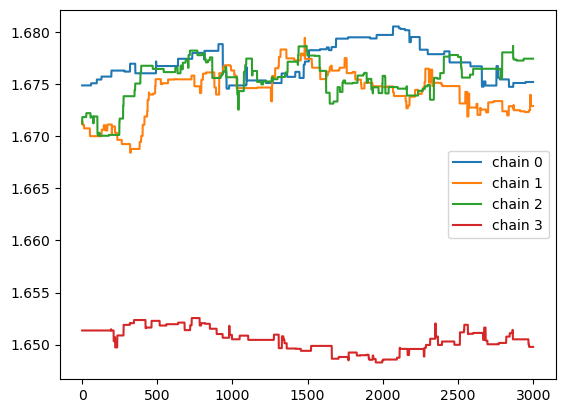

num_samples=100 num_tune=20 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=5 hws_std_err=0.001 relative_intensity_std_error=0.01
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
E        1.394  0.061   1.320    1.476      0.029    0.022       5.0   
sigma_E  0.014  0.009   0.001    0.028      0.004    0.003       5.0   
LI       0.061  0.012   0.050    0.089      0.005    0.004       5.0   
L0       0.110  0.028   0.078    0.150      0.013    0.010       5.0   
H0       0.160  0.015   0.139    0.180      0.007    0.005       5.0   

         ess_tail  r_hat  
E             4.0   3.90  
sigma_E      14.0   3.11  
LI           21.0   3.21  
L0           17.0   3.26  
H0           24.0   2.84  
------------------
------------------


/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


NameError: name 'fig' is not defined

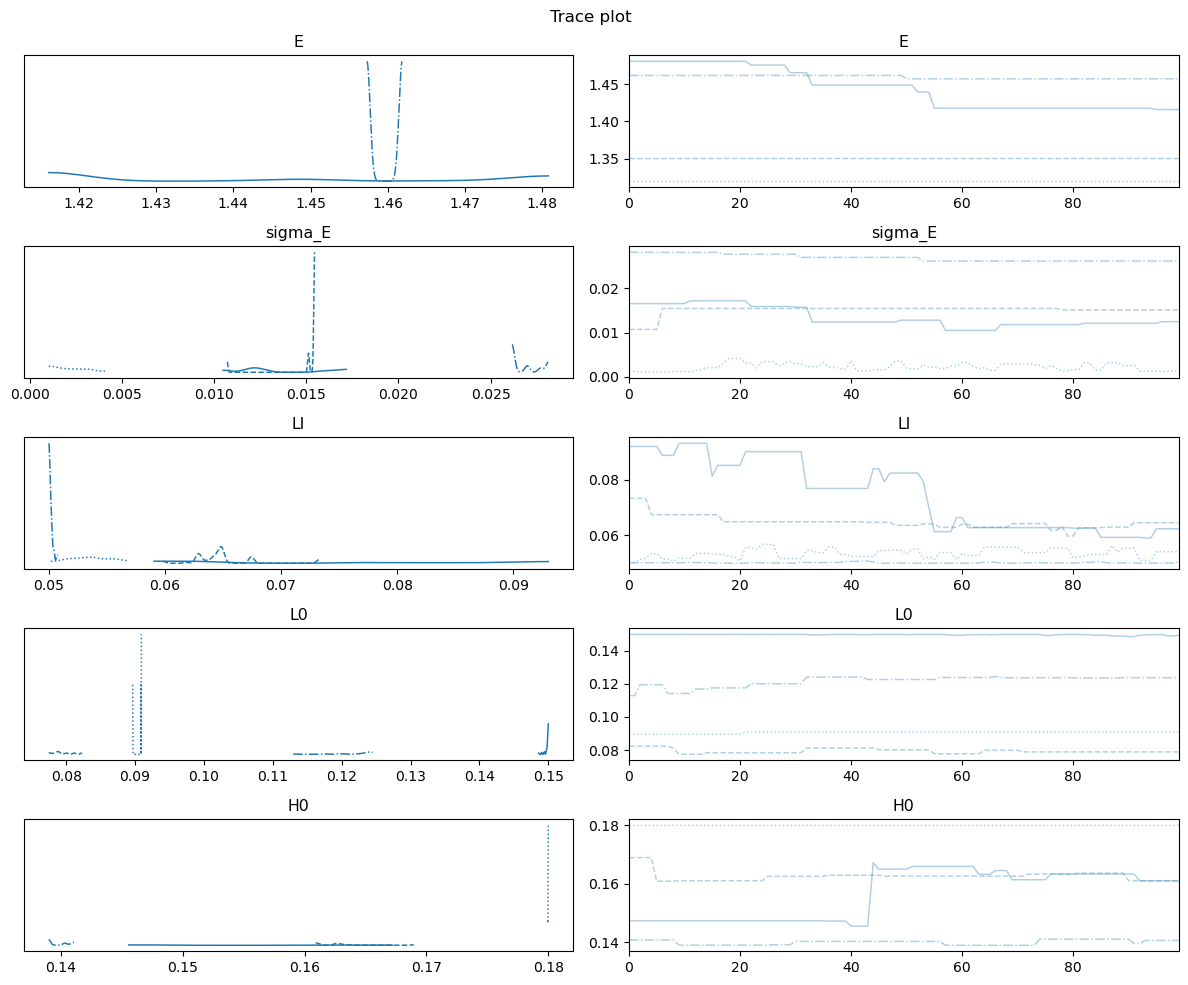

In [9]:
def plot_fit_results(name,Exp_data,  temperature_list, hws, save_folder="", savefig=False):
    print(name)
    model = model_dict_exp[name]
    df_summary = arviz.summary(model.idata)
    print(df_summary)
    print('------------------')
    print('------------------')
    fig_trace = model.plot_trace(None, save_folder="", savefig=False)
    fig.suptitle(name + f" rhat {df_summary['r_hat'].values.max()}")
    fig.show()           
    fig_fit = model.plot_posterior_prediction(Exp_data,  temperature_list, hws, save_folder="", savefig=False)
    return fig_trace, fig_fit



fig_trace, fig_fit = plot_fit_results(df.loc[0]['key'],Exp_data,  temperature_list, hws, save_folder="", savefig=False)        

        


Running on PyMC v5.10.3
num_samples=3000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.005 relative_intensity_std_error=0.1
[array(1.6452433), array(0.00106409), array(0.11764721), array(0.13227285), array(0.16497543)]


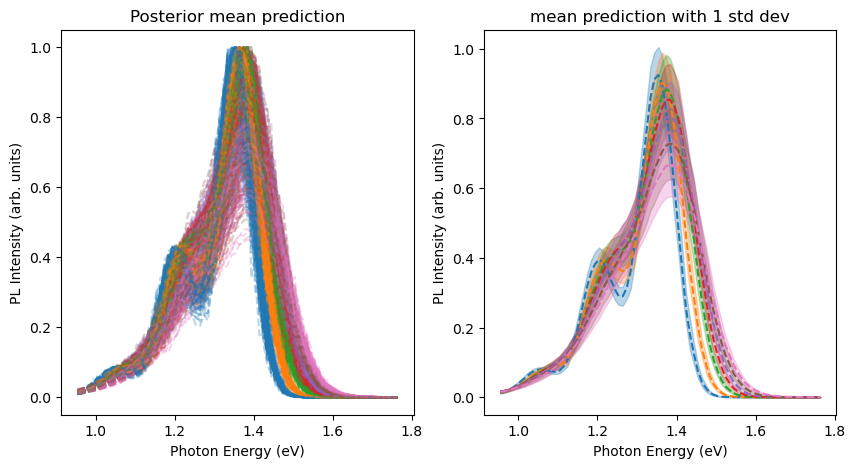

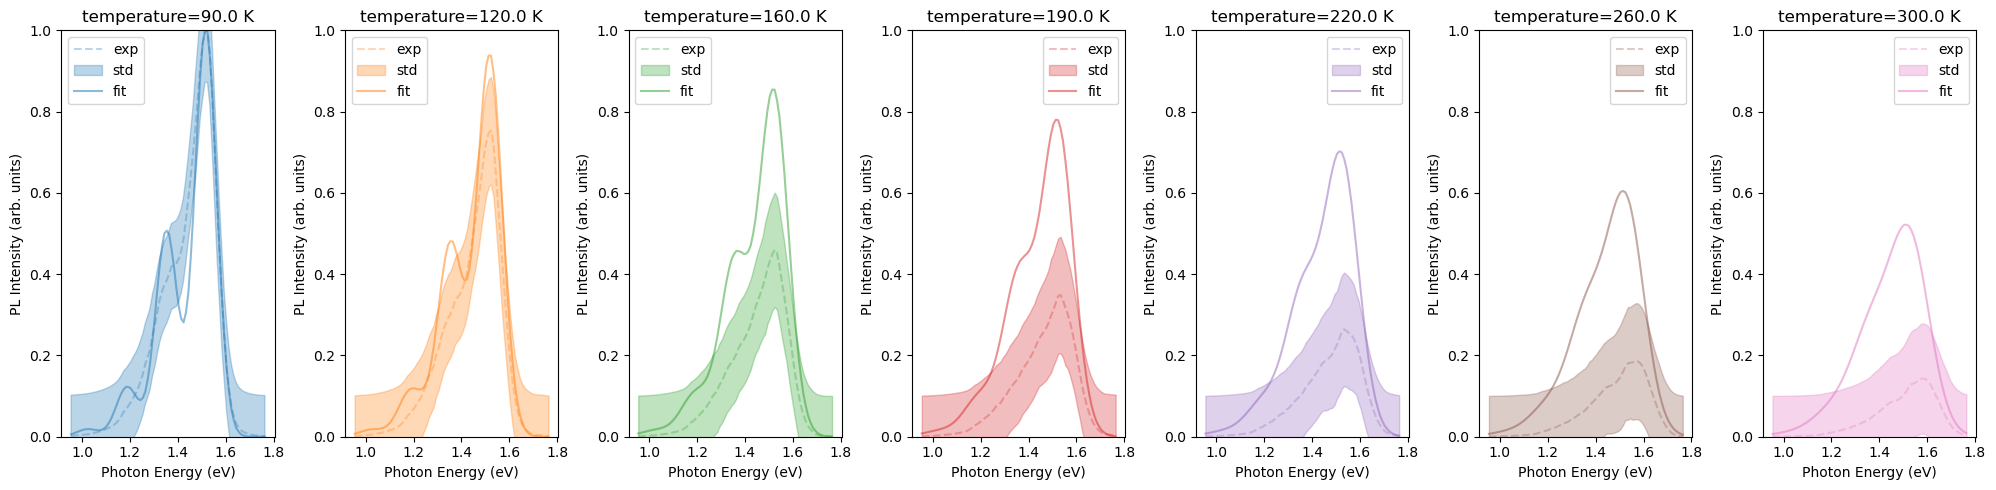

In [62]:
# plot exp data with variance
from pl_temp_fit import test_FIT_NEW
import importlib
importlib.reload(fit_experimental_PLT)
importlib.reload(PLPYMCModel)
def plot_exp_data_with_variance(index,Exp_data,  temperature_list, hws, save_folder="", savefig=False, theta_mean_list=None):
    print(df.loc[index]['key'])
    model = model_dict_exp[df.loc[index]['key']]
    info = df.loc[index]
    number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = info['number_free_parameters'], info['sigma'], info['Temp_std_err'], info['hws_std_err'], info['relative_intensity_std_error']
    
    model_config = {
                "number_free_parameters": number_free_parameters,
                "sigma": sigma,
                "Temp_std_err": Temp_std_err,
                "hws_std_err": hws_std_err,
                "relative_intensity_std_error": relative_intensity_std_error,
            }
    truemodel_pl, true_parameters = fit_experimental_PLT.generate_data(temperature_list, hws, **model_config)
    true_model_pl_list,variance,arg_max_variance = fit_experimental_PLT.plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=savefig)
    variance_data = variance.copy()
    argmax_data = np.argmax(Exp_data, axis=0)
    for i in range(len(temperature_list)):
        variance_data[:, i] = np.roll(variance_data[:, i], argmax_data[i]-arg_max_variance[i])
    variance_data = variance_data + sigma
    fig,ax = fit_experimental_PLT.plot_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder, savefig=savefig)
    if theta_mean_list is None:
        theta_mean = model.idata.posterior.mean(dim=["chain", "draw"])
        theta_mean_list = []
        for x in theta_mean.data_vars:
            theta_mean_list.append(
                theta_mean[x].values
            )  # theta_mean = theta_mean.to_dict()["values"]
    print(theta_mean_list)
    data_plot = PLPYMCModel.pl_trial(theta_mean_list, temperature_list, hws)
    data_plot = data_plot.reshape(len(hws), -1)
    data_plot = data_plot / max(data_plot.reshape(-1, 1))
    for i in range(len(temperature_list)):
        ax[i].plot(
            hws,
            data_plot[:, i],
            label="fit",
            linestyle="-",
            color="C" + str(i),
            alpha=0.5,

        )
        ax[i].legend(['exp','std','fit'])
        ax[i].set_ylim([0,1])

    return fig,ax
fig,ax = plot_exp_data_with_variance(3,Exp_data,  temperature_list, hws, save_folder="", savefig=False, theta_mean_list=None)


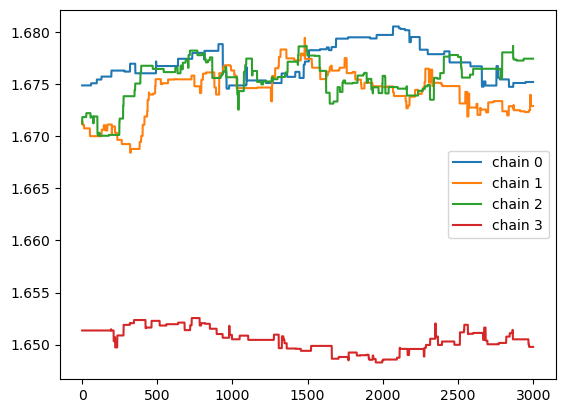

In [64]:
model = model_dict_exp[df.loc[0]['key']]
df_summary = arviz.summary(model.idata)
E = model.idata.posterior.data_vars['E']
import matplotlib.pyplot as plt
import numpy as np
E.shape
for i in range(4):
    plt.plot(np.arange(E.shape[1]),E[i,:],label=f"chain {i}")
plt.legend()

In [66]:
elem= 0
model = model_dict_exp[df.loc[elem]['key']]
df_summary = arviz.summary(model.idata)
chains = [0,1,2]
theta_mean_list = []
for key in model.idata.posterior.data_vars.keys():
    theta_mean_list.append(np.array(np.mean(model.idata.posterior.data_vars[key][chains,:].values)))
print(theta_mean_list)
fig,ax = plot_exp_data_with_variance(elem,Exp_data,  temperature_list, hws, save_folder="", savefig=False, theta_mean_list=theta_mean_list)


[array(1.6756112), array(0.00115049), array(0.1141376), array(0.12829028), array(0.17795717)]
num_samples=3000 num_tune=2000 sigma=0.002 temperature_list=7 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.05 relative_intensity_std_error=0.01


[array(1.63267988), array(0.00104314), array(0.12650371), array(0.11460478), array(0.15702823)]
num_samples=3000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.005 relative_intensity_std_error=0.1
[array(1.63267988), array(0.00104314), array(0.12650371), array(0.11460478), array(0.15702823)]


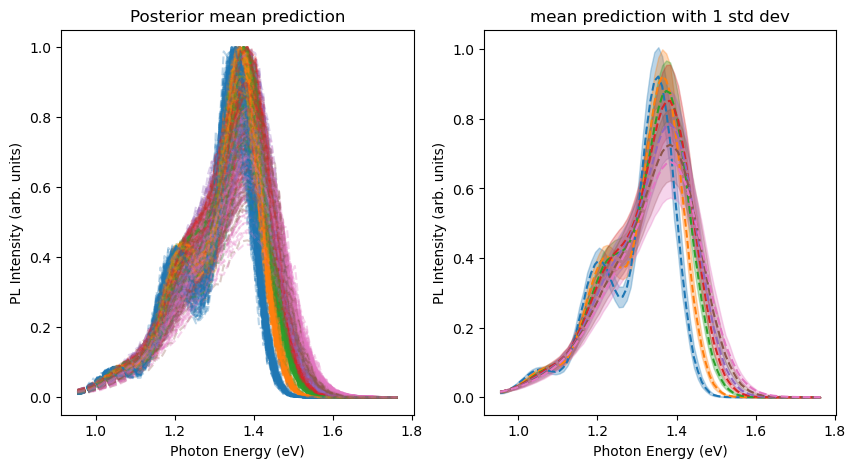

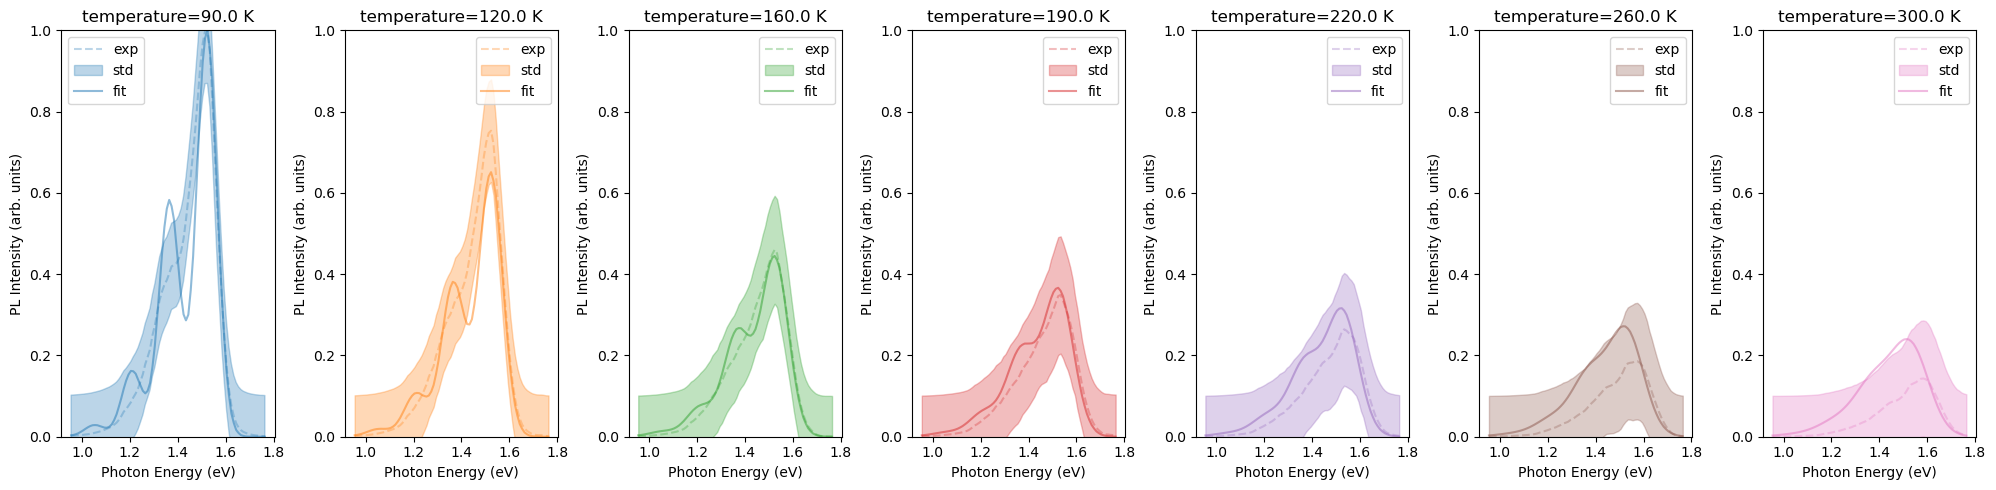

In [59]:
model = model_dict_exp[df.loc[3]['key']]
df_summary = arviz.summary(model.idata)
chains = [1,3]
theta_mean_list = []
for key in model.idata.posterior.data_vars.keys():
    theta_mean_list.append(np.array(np.mean(model.idata.posterior.data_vars[key][chains,:].values)))
print(theta_mean_list)
fig,ax = plot_exp_data_with_variance(3,Exp_data,  temperature_list, hws, save_folder="", savefig=False, theta_mean_list=theta_mean_list)

[array(1.65780672), array(0.00108503), array(0.10879071), array(0.14994092), array(0.17292263)]
num_samples=3000 num_tune=2000 sigma=0.01 temperature_list=7 number_free_parameters=5 Temp_std_err=2 hws_std_err=0.005 relative_intensity_std_error=0.1
[array(1.65780672), array(0.00108503), array(0.10879071), array(0.14994092), array(0.17292263)]


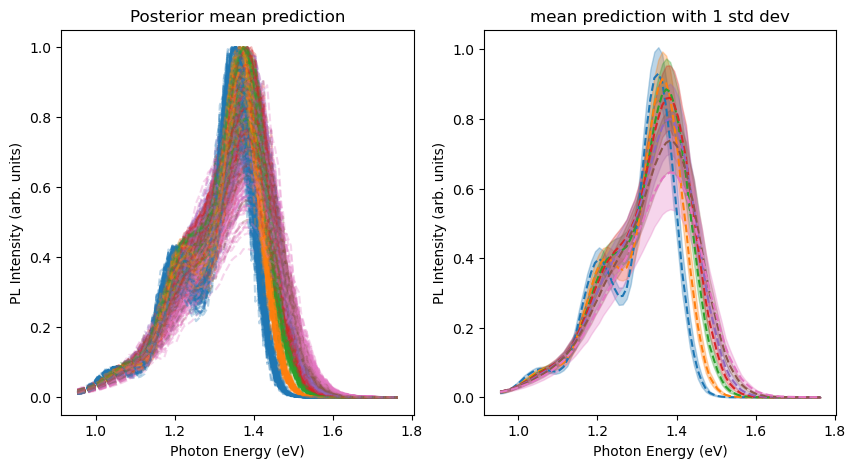

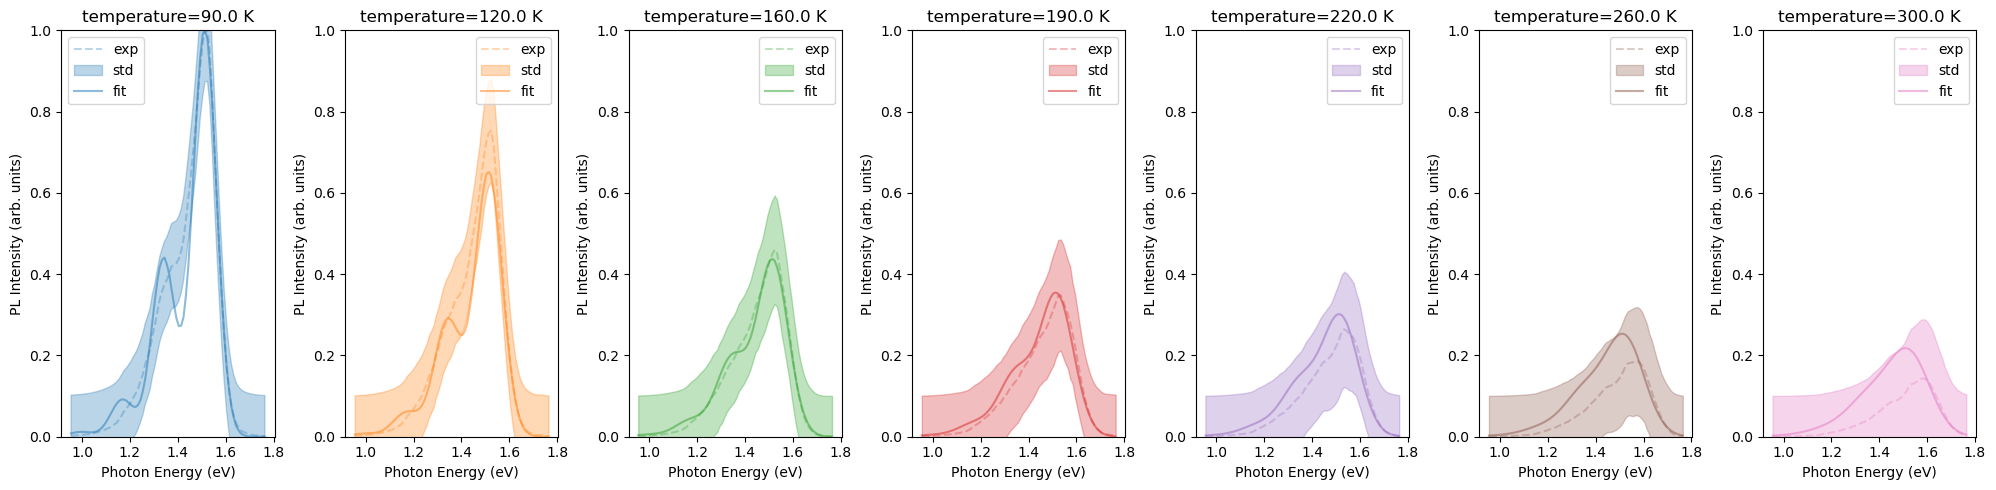

In [60]:
model = model_dict_exp[df.loc[3]['key']]
df_summary = arviz.summary(model.idata)
chains = [0,2]
theta_mean_list = []
for key in model.idata.posterior.data_vars.keys():
    theta_mean_list.append(np.array(np.mean(model.idata.posterior.data_vars[key][chains,:].values)))
print(theta_mean_list)
fig,ax = plot_exp_data_with_variance(3,Exp_data,  temperature_list, hws, save_folder="", savefig=False, theta_mean_list=theta_mean_list)